# This is my jam
### NTDS-project

In [225]:
%matplotlib inline
#importing all relevant packages
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pygsp import graphs, filters, plotting

plt.rcParams['figure.figsize'] = (10, 10)
plotting.BACKEND = 'matplotlib'

#Setting style for plotting
sns.set_style('whitegrid')
sns.set_palette('cubehelix',3)



## 1. Data loadig and cleaning
First we need to load the data for the project. The data is stored in three tsv files:
- jams.tsc: All jams created including some matadata about the jam
- followers.tsv: Who follows who
- likes.tv: Who has liked which jams

To understand and work with this data we will load it into dataframes and do some data cleaning

In [153]:
data= pd.read_csv('jams.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')

b'Skipping line 7872: expected 7 fields, saw 8\nSkipping line 11730: expected 7 fields, saw 9\nSkipping line 14131: expected 7 fields, saw 8\nSkipping line 58054: expected 7 fields, saw 8\nSkipping line 58754: expected 7 fields, saw 8\n'
b'Skipping line 847129: expected 7 fields, saw 8\n'
b'Skipping line 1091153: expected 7 fields, saw 8\nSkipping line 1175375: expected 7 fields, saw 8\n'
b'Skipping line 1225935: expected 7 fields, saw 8\nSkipping line 1255357: expected 7 fields, saw 8\nSkipping line 1279671: expected 7 fields, saw 8\n'
b'Skipping line 1330675: expected 7 fields, saw 8\n'
b'Skipping line 1448033: expected 7 fields, saw 8\nSkipping line 1543893: expected 7 fields, saw 8\n'
b'Skipping line 1579569: expected 7 fields, saw 8\nSkipping line 1612448: expected 7 fields, saw 8\n'
b'Skipping line 1784588: expected 7 fields, saw 8\n'


Importing the data was only possible if we allowed for bad lines to be skipped, however we see that it is less that 20 and are not very concerned with these lines as we assume it will not make a difference in the later analysis. 

By manually inspecting the raw data it is not difficult to find lines that are being read in a wrong way In parts of the data there are newlines and \t separators that are not placed correctly. This results in empty lines and lines where the data has been shifted to either side and slip between several lines. In order to figure out how many lines are concerned with these kinds of errors we sort the dataframe on the date and thus all the lines where the format of the field creation_date is not in a date format will appear at the end. We decided to simply remove all these lines so that the ones left are the ones read correctly. It should be noted that most of the information could have been recovered by manually inspecting and removing places with faulty new lines and tabs. However, we decided that it would be too time consuming for the project. It is observed that at maximum a few 100 jams have been removed (that potentially could have been restored) and in comparison with the more than 2.000.000 jams that are part of the analysis, this is very unlikely to have any real influence on the later analysis.

Furthermore, it is observed that some song titles and artists are NaN's.This might be due to some fault in the data collection, but could also simply be because it has been possible to create jams without specifying the artist or title and therefore we leave these jams in the dataset.

We see that all jam id's are unique and that all lines contain a user id and a creaton date.

In [154]:
data = data.sort_values(by='creation_date')[0:2090068-605]

In [15]:
description = data.describe()
description[0:2]

,jam_id,user_id,artist,title,creation_date,link,spotify_uri
count,2089463,2089463,2088228,2089077,2089463,2072585,1479763
unique,2089463,132297,240051,568426,1492,950444,401193


The social connections (network) is described by the followint dataframe where all followers are linked to the users they follow. In this dataframe we observe no values that seem faulty.

In [155]:
net = pd.read_csv('followers.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')

In [6]:
net.head(5)

,followed_user_id,follower_user_id
0,b99ebf68a8d93f024e56c65e2f949b57,1ebda3c5e05265626ab18401fb33a90a
1,c1066039fa61eede113878259c1222d1,1ebda3c5e05265626ab18401fb33a90a
2,d8a96caeef5c7d8dbdc9cec28aa9c044,1ebda3c5e05265626ab18401fb33a90a
3,2969c319775d884b860a897ba9d6156f,1ebda3c5e05265626ab18401fb33a90a
4,ff58e67948917e0ff71ba4b33e158365,1ebda3c5e05265626ab18401fb33a90a


The last dataframe contains all the likes and thus each user is linked to the jam they liked. This dataframe also seem to contain no faulty values.

In [156]:
likes = pd.read_csv('likes.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')

In [8]:
likes.head()

,user_id,jam_id
0,c1066039fa61eede113878259c1222d1,5d2bc46196d7903a5580f0dbedc09610
1,b99ebf68a8d93f024e56c65e2f949b57,8940ff2e8e38c8f1a4676e09d152c0cd
2,c1066039fa61eede113878259c1222d1,4849f8c893a792032dbc15eb77cfd0cd
3,c1066039fa61eede113878259c1222d1,4020b45a4c6d5515a3b62c489e169828
4,b99ebf68a8d93f024e56c65e2f949b57,4849f8c893a792032dbc15eb77cfd0cd


## 2. Unweighted social network

To create a simple unweighted network we look at the net dataframe and add all the unique user id's as nodes to the network. Next we add edges between all the relevant nodes by going through the net dataframe.

In [16]:
followed = list(net['followed_user_id'].unique())
followers = list(net['follower_user_id'].unique())

nodes = list(set(followed+followers))

In [17]:
#creating the network with nodes
G = nx.Graph()
G.add_nodes_from(nodes)

In [18]:
#adding all edges
for i in tqdm(range(len(net))):
    if net['followed_user_id'].iloc[i] != net['follower_user_id'].iloc[i]:
        G.add_edge(net['followed_user_id'].iloc[i],net['follower_user_id'].iloc[i],weight=1)

100%|██████████| 1603404/1603404 [05:12<00:00, 5123.71it/s]


Since we need to work with a connected graph for the signal processing, we chose the largest connected component.

In [19]:
nx.is_connected(G)

False

In [20]:
#Here we will keep the greatest component Gcc[0] for the further analysis
Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)

In [86]:
G = Gcc[0]

In [22]:
print('The unweigted network G has {} nodes.'.format(len(G.nodes())))
print('The unweigted network G has {} edges.'.format(G.size()))
print('The nodes in G has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G)).values()))/len(G.nodes())))

The unweigted network G has 100518 nodes.
The unweigted network G has 1294160 edges.
The nodes in G has an average degree of 25.75.


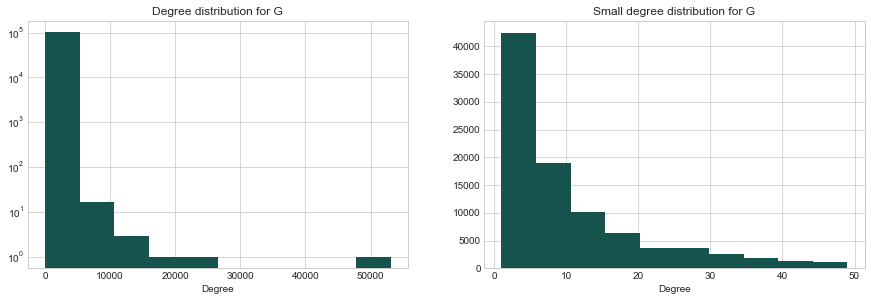

In [18]:
fig = plt.figure(1,figsize=(15,10))

#plotting degree distribution
degrees = np.array(list(dict(nx.degree(G)).values()))
plt.subplot(221)
plt.hist(degrees, log=True);
plt.title('Degree distribution for G');
plt.xlabel('Degree');

#plotting distribution for small degrees
small_degrees = degrees[degrees < 50]
plt.subplot(222)
plt.hist(small_degrees);
plt.title('Small degree distribution for G');
plt.xlabel('Degree');


In [19]:
G_adj = nx.adjacency_matrix(G)

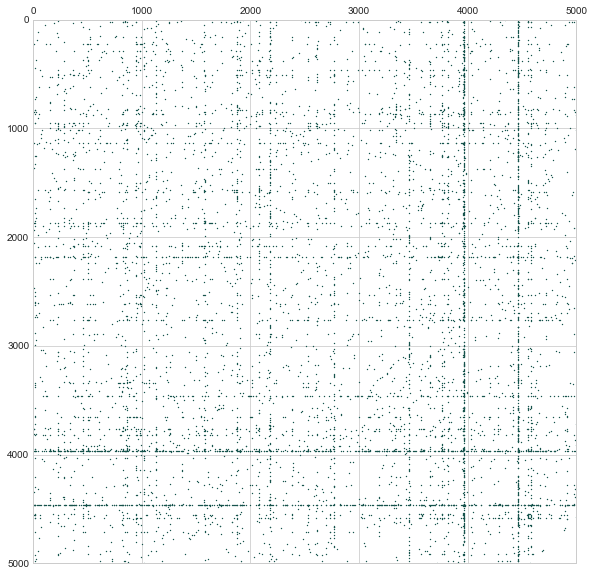

In [20]:
plt.figure(figsize=(10,10))
plt.spy(G_adj[0:5000,  0:5000],markersize=0.4);

## 3. Weighted Social network

In the later analysis when we want to observe how songs propagate trhough a network it is important to consider how well connected two given nodes are and not just that they are simply connected. If two users interact many times we assume that they are also more likely to be influenced by each other. Therfore we will create a weighted graph where the weights on the edges depend on the amount of times two users have liked each others jams.

In [157]:
merge = likes.merge(data[['jam_id','user_id']],on='jam_id')

In [158]:
merge.head()

,user_id_x,jam_id,user_id_y
0,c1066039fa61eede113878259c1222d1,5d2bc46196d7903a5580f0dbedc09610,c1066039fa61eede113878259c1222d1
1,b99ebf68a8d93f024e56c65e2f949b57,8940ff2e8e38c8f1a4676e09d152c0cd,b1c81a51f5286d70e5820ecb85aeba96
2,c1066039fa61eede113878259c1222d1,8940ff2e8e38c8f1a4676e09d152c0cd,b1c81a51f5286d70e5820ecb85aeba96
3,2969c319775d884b860a897ba9d6156f,8940ff2e8e38c8f1a4676e09d152c0cd,b1c81a51f5286d70e5820ecb85aeba96
4,c1066039fa61eede113878259c1222d1,4849f8c893a792032dbc15eb77cfd0cd,d8a96caeef5c7d8dbdc9cec28aa9c044


In [159]:
groups = merge.groupby(['user_id_x','user_id_y']).count()

In [160]:
groups.sort_values(by='jam_id',ascending=False).head()

,,jam_id
user_id_x,user_id_y,
8e01cba1a99a9eae7ffbb7bb76aac150,fd3292545fd8b2c8dcbdb86335052238,1723
a12e5a826d390a0a138c21841b8f34c7,fd3292545fd8b2c8dcbdb86335052238,1619
8eaf92d9023c44e657193e50f09e7725,fd3292545fd8b2c8dcbdb86335052238,1404
126932e6915c39fd6127c0c635461307,126932e6915c39fd6127c0c635461307,1307
dc87e7ab06a5aad596130c6966d2fe0c,fd3292545fd8b2c8dcbdb86335052238,1163


In [87]:
G_w = G

In [88]:
for i in tqdm(range(len(groups))):
    if groups.iloc[i].name[0] in G_w.nodes and groups.iloc[i].name[1] in G_w.neighbors(groups.iloc[i].name[0]):
            G_w[groups.iloc[i].name[0]][groups.iloc[i].name[1]]['weight'] += groups.iloc[i]['jam_id']

  6%|▌         | 79436/1384506 [01:44<28:40, 758.51it/s] 

KeyboardInterrupt: 

In [30]:
nx.write_gpickle(G_w,'G_w')

In [31]:
nx.is_connected(G_w)

True

In [32]:
print('The weigted network G_w has {} nodes.'.format(len(G_w.nodes())))
print('The weigted network G_w has {} edges.'.format(G_w.size()))
print('The nodes in G_w has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G_w,weight='weight')).values()))/len(G_w.nodes())))

The weigted network G_w has 100518 nodes.
The weigted network G_w has 1294160 edges.
The nodes in G_w has an average degree of 123.00.


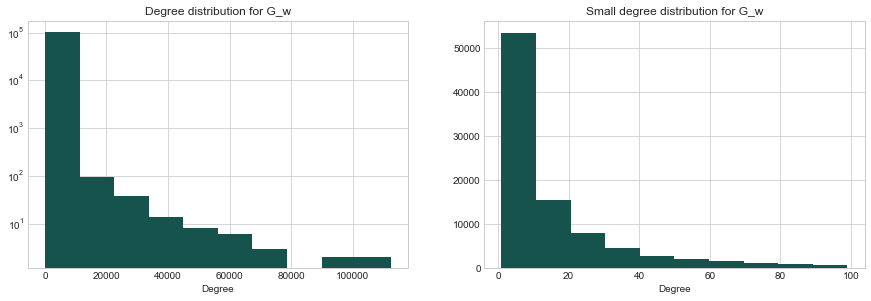

In [33]:
fig = plt.figure(1,figsize=(15,10))

#pltotting degree distribution
degrees_w = np.array(list(dict(nx.degree(G_w,weight='weight')).values()))
plt.subplot(221)
plt.hist(degrees_w, log=True);
plt.title('Degree distribution for G_w');
plt.xlabel('Degree');

#plotting the small degrees
small_degrees_w = degrees_w[degrees_w < 100]
plt.subplot(222)
plt.hist(small_degrees_w);
plt.title('Small degree distribution for G_w');
plt.xlabel('Degree');

## 4. The pruned network

We will now look at a pruned network where only nodes related to a given signal is kept. Later we will analyze the most relevant signals. We consider their relevance based on the amount of times the specific song has been jammed.

In [132]:
data[['jam_id','artist','title']].groupby(['artist','title']).count().sort_values(by='jam_id',ascending=False).head(20)

,,jam_id
artist,title,
Grimes,Oblivion,871
Arctic Monkeys,Do I Wanna Know?,835
Lorde,Royals,811
Alt-J,Breezeblocks,790
The Lumineers,Ho Hey,782
Of Monsters and Men,Little Talks,744
Alabama Shakes,Hold On,705
M83,Midnight City,692
CHVRCHES,The Mother We Share,690


In [161]:
def Create_network(artist,title,net,groups):
    data_network = data.loc[(data.artist==artist) & (data.title==title)]
    nodes_network = data_network['user_id']
    G = nx.Graph()
    G.add_nodes_from(nodes_network.values)
    
    #adding nodes and edges of followers
    for i in tqdm(range(len(net))):
        if net['followed_user_id'].iloc[i] in nodes_network.values and (net['followed_user_id'].iloc[i] != net['follower_user_id'].iloc[i]):
            G.add_node(net['follower_user_id'].iloc[i])
            G.add_edge(net['followed_user_id'].iloc[i],net['follower_user_id'].iloc[i],weight=1)
    
    #adding weights
    for i in tqdm(range(len(groups))):
        if groups.iloc[i].name[0] in G.nodes and groups.iloc[i].name[1] in G.neighbors(groups.iloc[i].name[0]):
            G[groups.iloc[i].name[0]][groups.iloc[i].name[1]]['weight'] += groups.iloc[i]['jam_id']
            
    return G
            

In [104]:
G_grimes = Create_network('Grimes','Oblivion',net,groups)

100%|██████████| 1384506/1384506 [11:27<00:00, 2013.67it/s]


In [121]:
nx.write_gpickle(G_grimes,'G_grimes')

In [162]:
G_grimes = nx.read_gpickle('G_grimes')

In [163]:
print('The weigted network G_grimes has {} nodes.'.format(len(G_grimes.nodes())))
print('The weigted network G_grimes has {} edges.'.format(G_grimes.size()))
print('The nodes in G_grimes has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G_grimes,weight='weight')).values()))/len(G_grimes.nodes())))

The weigted network G_grimes has 19876 nodes.
The weigted network G_grimes has 44060 edges.
The nodes in G_grimes has an average degree of 28.14.


In [168]:
#removing nodes with degree below 2
G_grimes_degrees = G_grimes.degree(G_grimes_nodes,weight='weight')
G_grimes_nodes = list(G_grimes.nodes)

for i in G_grimes_nodes:
    if G_grimes.degree[i] < 2:
        G_grimes.remove_node(i)

In [169]:
nx.is_connected(G_grimes)

False

In [170]:
#keeping the largest connected component
Gcc_grimes=sorted(nx.connected_component_subgraphs(G_grimes), key = len, reverse=True)
Gcc_grimes = Gcc_grimes[0]

In [172]:
print('The weigted network Gcc_grimes has {} nodes.'.format(len(Gcc_grimes.nodes())))
print('The weigted network Gcc_grimes has {} edges.'.format(Gcc_grimes.size()))
print('The nodes in Gcc_grimes has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(Gcc_grimes,weight='weight')).values()))/len(Gcc_grimes.nodes())))

The weigted network Gcc_grimes has 7400 nodes.
The weigted network Gcc_grimes has 31627 edges.
The nodes in Gcc_grimes has an average degree of 65.92.


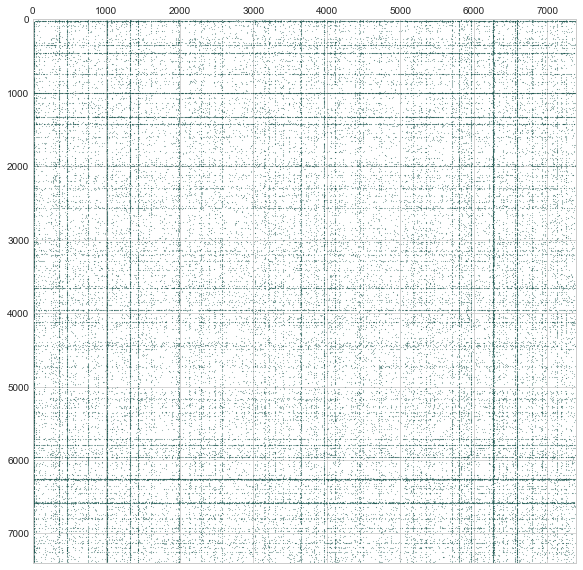

In [174]:
#plotting the adjecendy matrix
Gcc_grimes_adj = nx.adjacency_matrix(Gcc_grimes)
plt.figure(figsize=(10,10))
plt.spy(Gcc_grimes_adj,markersize=0.1)

## 5. signal

In [241]:
#Get relevant data
data_grimes = data.loc[(data.artist=='Grimes') & (data.title=='Oblivion')]
#keep only two columns
data_grimes = data_grimes[['user_id','creation_date']]
#keep only ones in the node list
data_grimes = data_grimes[(data_grimes.user_id.isin(Gcc_grimes_nodes))]
#initialize signal
data_grimes['signal']=0
data_grimes['signal'].iloc[0]=1
#change format to datetime
data_grimes['creation_date']=data_grimes['creation_date'].apply(pd.to_datetime)

C:\Users\Charlotte\Anaconda3\envs\ntds\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [242]:
#add signal has amount of days from the day of the first jam
for i in tqdm(range(1,len(data_grimes['user_id']))):
    a = data_grimes['creation_date'].iloc[i]-data_grimes['creation_date'].iloc[0]
    data_grimes['signal'].iloc[i] = a.days

  0%|          | 0/806 [00:00<?, ?it/s]C:\Users\Charlotte\Anaconda3\envs\ntds\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████| 806/806 [05:38<00:00,  2.38it/s]


In [243]:
#adding extra data, the nodes that are user that didnt share the song
data_grimes_extra = data[['user_id','creation_date']]
data_grimes_extra = data_grimes_extra[(data_grimes_extra.user_id.isin(Gcc_grimes_nodes))]

#set their signal
data_grimes_extra['signal']=2000

In [244]:
#append all data
data_grimes = data_grimes.append(data_grimes_extra)

In [245]:
#drop duplicates, but since the ones in the signal are at the top they will be kept
data_grimes = data_grimes.drop_duplicates('user_id',keep='first')

In [246]:
#sort the dataframe to be in the same order as the nodes
data_grimes['user_cat'] = pd.Categorical(data_grimes['user_id'],categories=list(Gcc_grimes.nodes),ordered=True)
data_grimes = data_grimes.sort_values('user_cat')

In [254]:
#pickle the data
data_grimes.to_pickle('data_grimes')

In [247]:
#create graph
G_grimes_f = graphs.Graph(Gcc_grimes_adj)

In [248]:
#compute fourier
G_grimes_f.compute_laplacian('normalized')
G_grimes_f.compute_fourier_basis()

2018-01-14 23:12:00,730:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (7400 x 7400) may take some time.


[-0.0001, 0.0001, -0.0001, 0.0001]

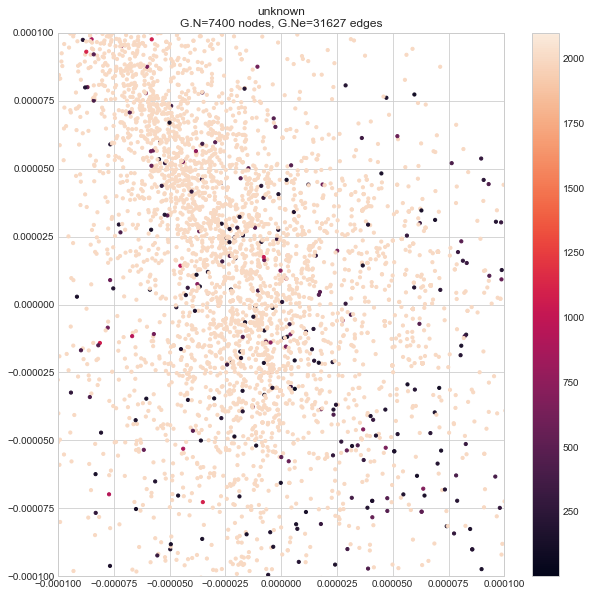

In [253]:
#plot the signal
signal = data_grimes['signal'].values
G_grimes_f.set_coordinates(G_grimes_f.U[:,1:3])
G_grimes_f.plot_signal(signal,vertex_size=10)
plt.axis([-0.0001,0.0001,-0.0001,0.0001])